# 7.3 컨볼루션층 구현 - 이미지 필터링

일반적인 신경망과 동일하게 순전파에서는 출력을 다음 층으로 전파시키고 역전파에서는 입력의 기울기를 앞 층으로 전파시킴

* 생성자는 객체가 생성되는 순간 자동으로 호출되는 메소드
* self가 붙어 있는 변수는 다른 메소드와 공유하는 인스턴스 변수

In [1]:
class ConvLayer:
    
    # x_ch: 입력 채널 수, x_h: 입력 이미지 높이, x_w: 입력 이미지 너비
    # n_fit: 필터 수, fit_h: 필터 높이, fit_w: 필터 너비
    # stride: 스트라이드 너비, pad: 패딩 너비
    
    def __init__(self, x_ch, x_h, n_fit, fit_h, fit_w, stride, pad):
        
        # 파라미터 정리
        self.params = ( x_ch, x_h, x_w, n_fit, fit_h, fit_w, stride, pad)
        
        # 파라미터 편향 초깃값
        self.w = wb_width + np.random.randn(n_fit, x_ch, fit_h, fit_w)
        self.b = wb_width + np.random.randn(1, n_fit)
        
        # 출력 이미지 크기
        self.y_ch = n_fit # 출력 채널 수 
        self.y_h = (x_h - fit_h) // stride + 1 # 출력 높이
        self.y_w = (x_w - fit_w + 2*pad) // stride + 1 # 출력 너비

* 생성자(init메소드)에서 변경하거나 외부에서 접근할 필요가 없는 파라미터를 self.params에 정리
* 필터(self.w)와 편향(b)의 초깃값 설정
* 출력 이미지의 채널 수, 높이, 너비에는 외부애서 접근할 수 있도록 self가 붙어 있음

## 순전파

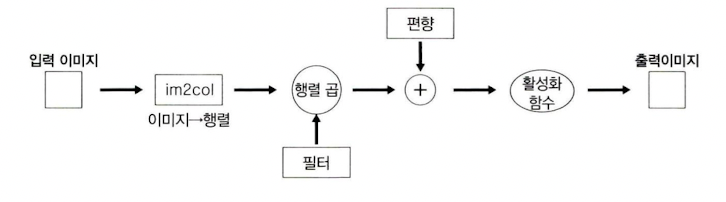

im2col에 의해 변환된 행렬을 cols라고 하면, 이 cols와 필터의 행렬 곱으로 컨볼루션이 수행되고, 편향을 더해 활성화 함수에서 처리된 것이 출력

1. im2col에 의해 입력 이미지를 행렬로 변환
2. 여러 개의 필터를 하나의 행렬로 변환
3. 입력 이미지를 나타내는 행렬과 필터를 나타내는 행렬의 행렬 곱 계산
4. 편향 더하기
5. 출력 형태를 갖춤
6. 활성화 함수에 의한 처리

In [2]:
def forward(self, x):
    n_bt = x.shape[0]
    x_ch, x_h, n_flt, flt_h, flt_w, stride, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

    # 입력 이미지와 필터를 행렬로 변환
    self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad) # 필터
    self.w_col = self.w.reshape(n_fit, x_ch*flt_h*flt_w) # 필터를 행렬로 변환한 것
    
    # 출력 계산: 행렬 곱, 편향 더하기, 활성화 함수
    u = np.dot(self.w_col, self.cols).T + self.b
    self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0,3,1,2)
    self.y = np.where(self.u <= 0, 0, self.u)

## 역전파

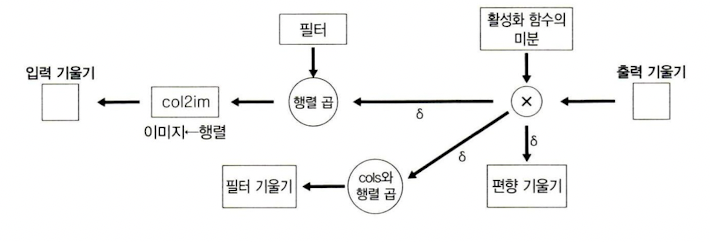

아래 층으로부터 전파된 출력 기울기에 활성화 함수 미분 결과를 곱한 것이 델타라고 하면 편향의 기울기는 델타가 된다. 필터의 기울기는 이 델타와 cols의 행렬 곱으로 구할 수 있고, 델타와 필터의 행렬 곱은 cols 형태가 되는데 이것을 col2lim으로 이미지의 형태로 되돌린 것이 입력 기울기가 된다.
* 델타를 사용해 필터, 가중치와 입력 기울기를 구하는 점은 일반적인 신경망과 비슷

1. delta = 출력 기울기 X 활성화 함수의 미분
2. 필터 기울기 = cols와 delta의 행렬 곱
3. 편향 기울기 = delta
4. cols 기울기 = delta와 필터의 행렬 곱
5. 입력 기울기 = col2im (cols 기울기)

In [3]:
def backward(self, grad_y):
    n_bt = grade_y.shape[0]
    x_ch, x_h, n_flt, flt_h, flt_w, stride, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
    
    # delta
    delta = grad_y * np.where(self, u <= 0, 0, 1)
    delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
    
    # 필터와 편향 기울기
    grad_w = np.dot(self.cols, delta)
    self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
    self.grad_b = np.sum(delta, axis =0)
    
    # 입력 기울기
    grad_cols = np.dot(delta, self.w_col)
    x_shape = (n_bt, x_ch, x_h, x_w)
    self.grad_x = col2im(grad_cols.T, x_shape, flt_h,
                        flt_w, y_h, y_w, stride, pad)

# 7.4 폴링층 구현 -이미지 크기 축소

In [4]:
class PoolingLayer:
    # x_ch : 입력 채널 수 , x_h : 입력 이미지 높이, x_w : 입력 이미지 너비
    # pool : 폴링 영역 크기, pad : 패딩 너비
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        self.y_ch = x_ch # 출력 채널 수
        self.y_h = x_h // pool if x_h % pool == 0 else x_h // pool + 1 # 출력 높이
        self.y_w = x_w //pool if x_w % pool == 0 else x_w // pool + 1 # 출력 너비
        

## 순전파

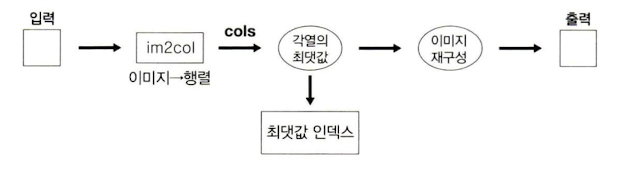

1. im2col을 이용해 입력 이미지를 행렬로 변환
2. 각 열의 최댓값을 구함
3. 구한 각 최댓값으로 이미지를 재구성하고 출력으로 설정
4. 각 열에서 최댓값의 인덱스를 저장함

In [5]:
def forwaed(self, x):
    n_bt = x.shape[0]
    x_ch, x_h, x_w, pool, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
    
    # 입력 이미지를 행렬로 변환
    cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
    cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
    
    # 출력 계산: 맥스폴링
    y = np.max(cols, axis = 1)
    self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
    
    # 최댓값 인덱스 저장
    self.max_index = np.argmax(cols, axis =1)

## 역전파

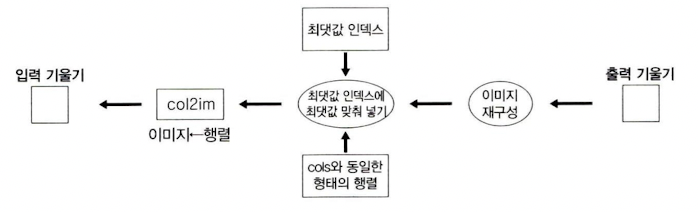

1. 출력 기울기를 이미지 형태에서 직선의 형태로 변환한다
2. cols와 같은 크기의 행렬을 만든다
3. 이 행렬의 각 열에서 최댓값이 있었던 위치에 출력 기울기를 맞춰 넣는다
4. col2im을 이용해 행렬을 이미지의 형태로 변환하여 입력 기울기로 설정한다

In [6]:
def backward(self, grad_y):
    n_bt = grad_y.shape[0]
    x_ch, x_h, x_w, pool, pad = self.params
    y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
    
    # 출력 기울기의 출력 변경
    grad_y = grad_y.transpose(0,2,3,1)
    
    # 행렬 생성
    grad_cols = np.zeos((pool*pool, grad_y.size))
    
    # 각 열의 최댓값이 있던 위치에 출력 기울기 입력
    grad_cols[self.max_index.reshape(-1),
             np.arange(grad_y.size)]= grad_y.reshape(-1)
    grad_cols = grad_cols.transpose(5, 0, 1, 2, 3, 4)
    grad_cols = grad_cols.reshape(y_ch*pool*pool, n_bt*y_h*y_w)
    
    #입력 기울기
    x_shape = (n_bt, x_ch, x_h, x_w)
    self.grad_x = col2im(grad_cols, x_shape, pool,
                         pool, y_h, y_w, pool, pad)

# 7.5 전결합층 구현

In [7]:
# -- 전결합 은닉층 --
class MiddleLayer:
    
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
        
# -- 전결합 출력층 --
class OutputLayer:
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis = 1).reshape(-1, 1)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.X.T, delta)
        self.grad_b = np.sum(delta, axis = 0)
        
        self.grad_x = np.dot(delta, self.w.T)

전결합층은 일반적인 신경망의 층과 완전히 일치하기 때문에 지금까지 살펴본 다른 층과 구현 방법이 동일
* 은닉층의 활성화 함수는 relu, 출력층의 활성화 함수는 소프트맥스, 손실함수는 교차 엔트로피 오차